In [1]:
%matplotlib inline

from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Pandas options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)
# pd.options.display.float_format = '{:,.6f}'.format

#Set seaborn plot theme
sns.set_style('darkgrid')

# ACS Tables

In [2]:
query = """
SELECT table_id, row_count FROM `fccdsicapstone-218522.broadband.__TABLES__`
"""
tables = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

mask = tables.table_id.str.contains('acs') & tables.row_count.between(190000, 220000)
tables[mask].sort_values('row_count', ascending=False)

,table_id,row_count
57,acs_blockgroup_pop_2014,216367
56,acs_blockgroup_2014,216367
55,acs_blockgroup2_2014,216367
51,acs_blockgroup_2016,216362
53,acs_blockgroup_pop_2016,216362
52,acs_blockgroup_pop_2015,216362
48,acs_blockgroup2_2015,216362
49,acs_blockgroup2_2016,216362
50,acs_blockgroup_2015,216362
34,acs_with_geo_2014,216330


# census_block, left join fcc and acs attributes

In [65]:
query = """
WITH block_level AS (
  SELECT 
    SUBSTR(block.block_code, 0, 12) AS block_group
    , block.total_length 
    , block.land_area
    , block.elevation_mean
    , block.elevation_range
    , CASE WHEN fcc.block_code IS NULL THEN 0 ELSE 1 END AS int_avail
    , fcc_demography.population_2016
  FROM broadband.census_block block
  LEFT JOIN (SELECT DISTINCT block_code FROM broadband.fcc WHERE file_date = 201706) fcc
    ON block.block_code = fcc.block_code
  LEFT JOIN broadband.fcc_demography
    ON block.block_code = fcc_demography.block_code
  WHERE fcc_demography.housing_unit_2016 > 0
),
block_group_level AS ( 
  SELECT 
    block_group
    , AVG(int_avail) AS int_avail_per
    , SUM(total_length) AS total_road_length
    , SUM(CASE WHEN int_avail = 1 THEN population_2016 ELSE 0 END) AS covered_population
    , SUM(land_area) AS total_land_area
    , AVG(elevation_mean) AS avg_elevation
    , AVG(elevation_range) AS avg_elevation_range
  FROM block_level
  GROUP BY block_group
)

SELECT DISTINCT
  block_group_level.*
  --, acs_blockgroup_2016.race_total AS population
  , acs_blockgroup_2016.median_household_income_in_the_past_12_months AS income
  , acs_housing_unit.estimate_total AS housing_units
  , acs_education_average.avg_years_of_edu
  , acs_employment_percentage.unemployment_rate
  --, acs_gender_age.male_ratio
  , acs_gender_age.avg_age
  --, SAFE_DIVIDE(acs_blockgroup_2016.white, acs_blockgroup_2016.race_total) AS white_ratio
  --, SAFE_DIVIDE(acs_blockgroup_2016.black_or_african_american, acs_blockgroup_2016.race_total) AS black_ratio
  --, SAFE_DIVIDE(acs_blockgroup_2016.asian, acs_blockgroup_2016.race_total) AS asian_ratio
  --, SAFE_DIVIDE(acs_blockgroup_2016.american_indian_and_alaska_native, acs_blockgroup_2016.race_total) AS native_ratio
  --, SAFE_DIVIDE(acs_blockgroup_2016.hispanic_or_latino, acs_blockgroup_2016.ethnicity_total) AS hispanic_ratio
FROM block_group_level
LEFT JOIN broadband.acs_blockgroup_2016
  ON block_group_level.block_group = acs_blockgroup_2016.block_group_code
LEFT JOIN broadband.acs_housing_unit
  ON block_group_level.block_group = acs_housing_unit.block_group_code
LEFT JOIN broadband.acs_education_average
  ON block_group_level.block_group = acs_education_average.block_group_code
LEFT JOIN broadband.acs_employment_percentage
  ON block_group_level.block_group = acs_employment_percentage.block_group_code
LEFT JOIN broadband.acs_gender_age
  ON block_group_level.block_group = acs_gender_age.block_group_code
LEFT JOIN broadband.acs_hispanic
  ON block_group_level.block_group = acs_hispanic.block_group_code
"""

data = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

In [66]:
data.shape

(215566, 12)

### Missing values

In [67]:
data.count() / data.shape[0] * 100

block_group            100.000000
int_avail_per          100.000000
total_road_length      100.000000
covered_population     100.000000
total_land_area        100.000000
avg_elevation          100.000000
avg_elevation_range    100.000000
income                  99.968455
housing_units           92.114712
avg_years_of_edu        96.274459
unemployment_rate       93.894213
avg_age                 92.077600
dtype: float64

Text(0.5,0,'Internet availability percentage')

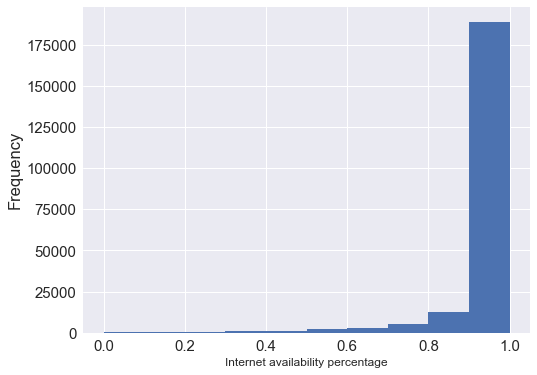

In [68]:
ax = data.int_avail_per.plot(kind='hist', figsize=(8, 6))
ax.set_xlabel('Internet availability percentage', fontsize=12)

In [69]:
data.int_avail_per.describe()

count    215566.000000
mean          0.958990
std           0.114091
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: int_avail_per, dtype: float64

In [70]:
full_coverage = (data.int_avail_per == 1).sum() / data.shape[0] * 100
print('block_group with full coverage', 100 - full_coverage)
print('block_group without full coverage', full_coverage)

block_group with full coverage 24.538192479333475
block_group without full coverage 75.46180752066653


# Correlation Analysis

Removing ethnicity & NA

In [71]:
existing_data = data.dropna()
existing_data.describe()

,int_avail_per,total_road_length,covered_population,total_land_area,avg_elevation,avg_elevation_range,avg_years_of_edu,unemployment_rate,avg_age
count,198063.000000,1.980630e+05,198063.000000,1.980630e+05,198063.000000,198063.000000,198063.000000,198063.000000,198063.000000
mean,0.960422,6.054138e+04,1452.599526,2.630370e+07,256.702704,10.316860,13.184853,0.095136,38.585954
std,0.112717,1.577948e+05,861.779971,1.529762e+08,354.346628,18.776211,1.452703,0.114988,6.618027
min,0.000000,0.000000e+00,0.000000,4.620000e+02,-59.989834,0.000000,3.937500,0.000000,15.810897
25%,1.000000,9.066007e+03,914.000000,4.523380e+05,45.521853,1.500000,12.345291,0.032389,34.364073
50%,1.000000,1.734655e+04,1255.000000,1.172305e+06,183.413284,4.205882,13.133903,0.066826,38.263711
75%,1.000000,4.524769e+04,1761.000000,8.129604e+06,284.004083,11.000000,14.073855,0.120991,42.222800
max,1.000000,7.780613e+06,35180.000000,1.144787e+10,3260.102705,720.090909,26.000000,10.875000,90.769231


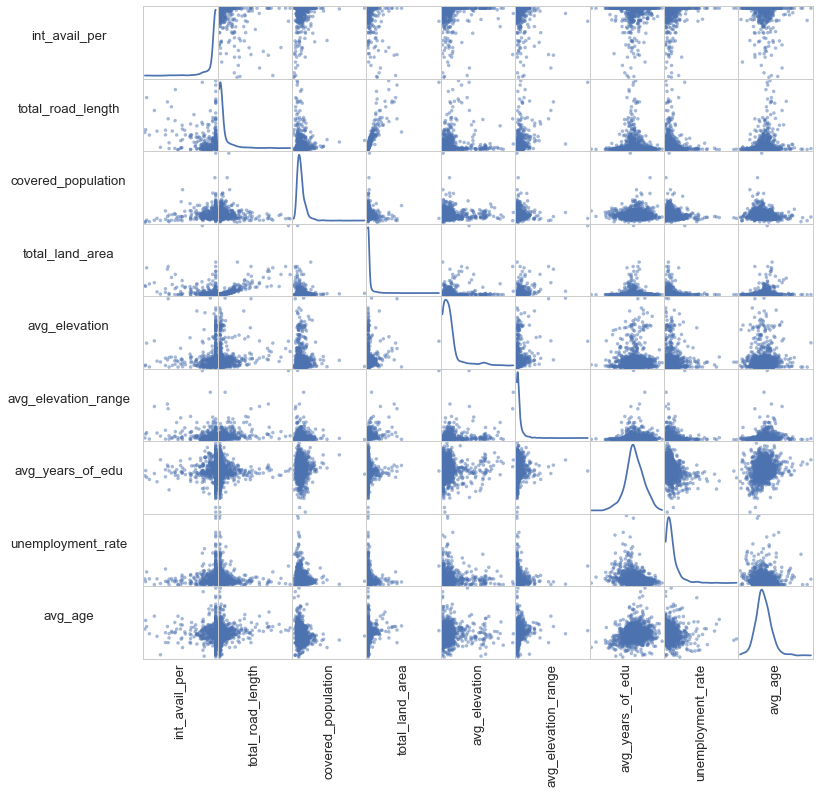

In [141]:
from pandas.plotting import scatter_matrix

sns.set_style('whitegrid')
sm = scatter_matrix(existing_data.sample(1000), figsize=(12, 12), diagonal='kde')

for s in sm.reshape(-1):
    #Change label rotation
    s.xaxis.label.set_rotation(90)
    s.yaxis.label.set_rotation(0)
    
    # offset label when rotating to prevent overlap of figure
    s.get_yaxis().set_label_coords(-1.0, 0.5)
    
    # Hide all ticks
    s.set_xticks(())
    s.set_yticks(())

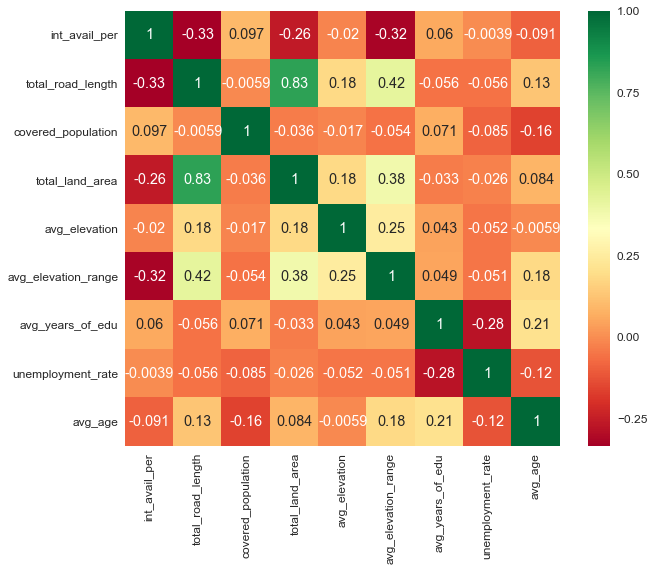

In [77]:
corr = existing_data.corr()

sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, ax=ax, cmap='RdYlGn', square=True, annot=True)

# Linear Model

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

X = existing_data.drop(['block_group', 'int_avail_per'], axis=1)
y = existing_data['int_avail_per']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = Lasso()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Score:", score)

Score: 0.12701795480954203


In [148]:
coefficients = pd.DataFrame(list(zip(X.columns, model.coef_)), columns=['feature', 'coef'])
coefficients.sort_values('coef', ascending=False)

,feature,coef
1,covered_population,1.122844e-05
3,avg_elevation,5.757999e-06
2,total_land_area,5.744488e-11
5,income,5.952261e-12
4,avg_elevation_range,-0.000000e+00
6,housing_units,-0.000000e+00
7,avg_years_of_edu,0.000000e+00
8,unemployment_rate,-0.000000e+00
9,avg_age,-0.000000e+00
0,total_road_length,-2.838957e-07
